In [62]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

RANDOM_STATE = 42


In [63]:
# Define project directories
PROJECT_ROOT = Path("..").resolve()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
SPLITS_DIR = PROJECT_ROOT / "data" / "splits"
REPORTS_DIR = PROJECT_ROOT / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"

# Create directories if they don't exist
DATA_RAW.mkdir(parents=True, exist_ok=True)
SPLITS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

In [64]:
df = pd.read_csv(DATA_RAW / "house_prices_train.csv")

In [65]:
TARGET_COL = "SalePrice"

# Separate features and target variable
y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

In [66]:
train_idx = np.load(SPLITS_DIR / "train_indices.npy")

X_train = X.loc[train_idx].copy()
y_train = y.loc[train_idx].copy()

In [67]:
# Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.to_list()
if 'Id' in numeric_cols:
    numeric_cols.remove('Id')
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.to_list()

print(f"Categorical columns: {categorical_cols}")
print(f"Numeric columns: {numeric_cols}")

Categorical columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Numeric columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea'

In [68]:
# Define preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)), 
    ]
)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [69]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [70]:
hgb_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", HistGradientBoostingRegressor(
            max_iter=120,  
            learning_rate=0.1254335218612733, 
            max_depth=None,  
            random_state=RANDOM_STATE,
            min_samples_leaf=11, 
            max_leaf_nodes=23, 
            early_stopping=True,  
            validation_fraction=0.1, 
        )),
    ]
)

log_target_model = TransformedTargetRegressor(
    regressor=hgb_model,
    func=np.log1p,   
    inverse_func=np.expm1,  
)

log_target_model.fit(X_train, y_train)


,regressor,Pipeline(step...m_state=42))])
,transformer,None
,func,<ufunc 'log1p'>
,inverse_func,<ufunc 'expm1'>
,check_inverse,True
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [71]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [75]:
# Generate OOF predictions
y_pred = cross_val_predict(
    log_target_model,
    X_train,
    y_train,
    cv=cv,
    n_jobs=-1
)

# Ensure y_true matches the training data
y_true = y_train

# Calculate residuals
residuals = y_true - y_pred

# Save residuals to CSV files
abs_error = np.abs(residuals)

# Calculate relative error
relative_error = residuals / y_true

# Create a DataFrame with all metrics
metrics_df = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred,
    'residuals': residuals,
    'abs_error': abs_error,
    'relative_error': relative_error
}).sort_values(by='abs_error', ascending=False)

print(metrics_df.head(10))

metrics_df.to_csv(REPORTS_DIR / 'error_analysis_df.csv', index=False)
metrics_df.describe()


      y_true         y_pred      residuals      abs_error  relative_error
1182  745000  460306.489024  284693.510976  284693.510976        0.382139
1298  160000  375733.134721 -215733.134721  215733.134721       -1.348332
523   184750  395650.159200 -210900.159200  210900.159200       -1.141543
803   582933  399585.955819  183347.044181  183347.044181        0.314525
1324  147000  311622.401931 -164622.401931  164622.401931       -1.119880
688   392000  228932.165510  163067.834490  163067.834490        0.415989
313   375000  224548.254826  150451.745174  150451.745174        0.401205
1373  466500  334804.857037  131695.142963  131695.142963        0.282305
197   235000  359168.738283 -124168.738283  124168.738283       -0.528378
769   538000  425367.308320  112632.691680  112632.691680        0.209354


,y_true,y_pred,residuals,abs_error,relative_error
count,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,181441.541952,179561.307282,1880.234670,17096.180733,-0.011391
std,77263.583862,69317.423707,28081.564101,22351.346824,0.155182
min,34900.000000,60464.315015,-215733.134721,8.003574,-1.348332
25%,130000.000000,131401.818580,-10257.888820,4795.253817,-0.065531
50%,165000.000000,164340.358824,648.668292,10963.812024,0.003923
75%,214925.000000,210262.018993,12237.156277,20852.393929,0.070778
max,745000.000000,514693.819458,284693.510976,284693.510976,0.415989


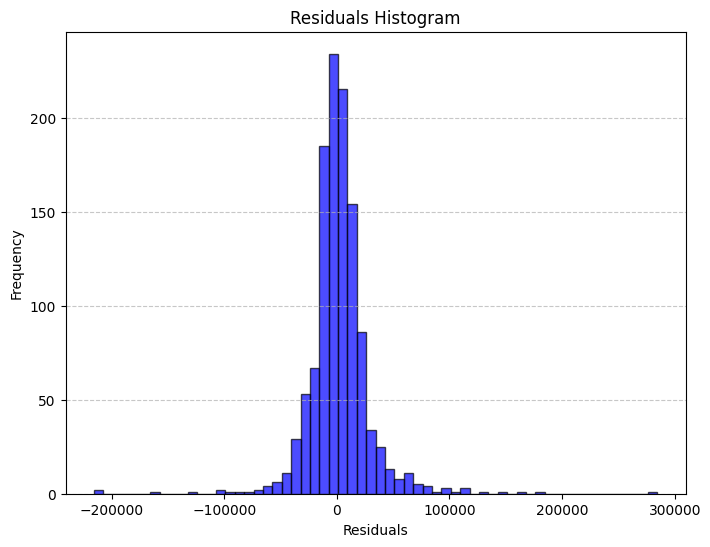

In [73]:
# Plot histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=60, color='blue', edgecolor='black', alpha=0.7)
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

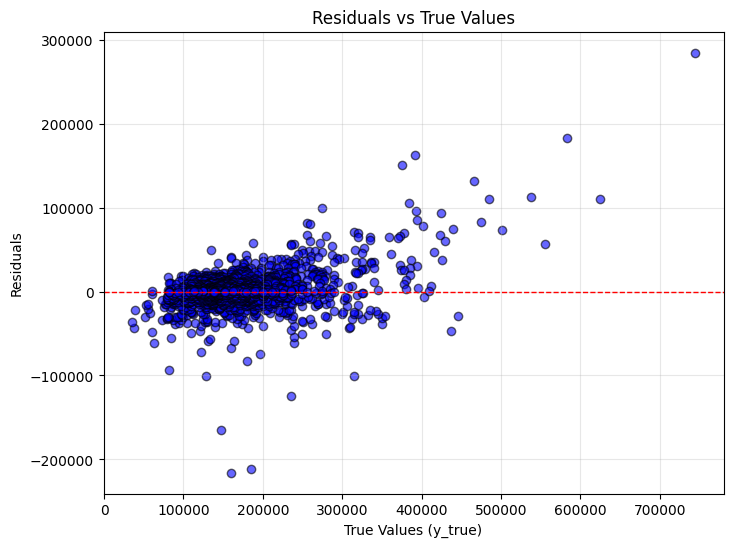

In [74]:
# Scatter plot of residuals
plt.figure(figsize=(8, 6))
plt.scatter(metrics_df['y_true'], metrics_df['residuals'], alpha=0.6, color='blue', edgecolor='black')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  # Horizontal line at y=0
plt.title('Residuals vs True Values')
plt.xlabel('True Values (y_true)')
plt.ylabel('Residuals')
plt.grid(alpha=0.3)
plt.show()